### Sequence to Sequence model using LSTM layers and keras

In [21]:
from random import randint
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten, InputLayer, Input, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

#### Function to Train and Test given model (Early stopping monitor = val_loss)

In [2]:
def train_test(model,
               X_train,
               y_train,
               X_test,
               y_test,
               epochs=100,
               verbose=0,
               patience=5):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ckp = ModelCheckpoint("lstm_model.keras", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

    # train model
    print(f"Training for {epochs} epochs")

    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, verbose=verbose, callbacks=[es, ckp])
    print("Training complete")


    # evaluate model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Train Accuracy:")
    print(f"Train: {train_acc:.3f}")
    print(f"Test Accuracy:")
    print(f"Test: {test_acc:.3f}")

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


    # checking a few examples
    print("Some examples...")
    for _ in range(10):
        X,y = get_reversed_pairs(n_timesteps, n_features)
        yhat = model.predict(X, verbose=0)
        print('Input',one_hot_decode(X[0]),
				'Expected:', one_hot_decode(y[0]),
					'Predicted', one_hot_decode(yhat[0]),
						'', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )

#### Functions to generate a Seq2Seq Dataset and One hot encode and decode input and output sequences

In [3]:
def generate_sequence(length, n_unique):
    return [randint(1, n_unique-1) for _ in range(length)]

In [4]:
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

In [5]:
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [6]:
def get_reversed_pairs(time_steps, n_features, verbose=False):
    # generate random sequence
    sequence_in = generate_sequence(time_steps, n_features)
    sequence_out = sequence_in[::-1]

    # one hot encode
    X = one_hot_encode(sequence_in, n_features)
    y = one_hot_encode(sequence_out, n_features)

    # reshape as 3D
    X = X.reshape(1, X.shape[0], X.shape[1])
    y = y.reshape(1, y.shape[0], y.shape[1])

    if verbose:
        print("In raw Format")
        print("X: ",sequence_in)
        print("y: ",sequence_out)
        print("In one hot format")
        print("X: ",X)
        print("y: ",y)

    return X,y

In [7]:
def create_dataset(train_size,
                   test_size,
                   time_steps,
                   vocabulary_size,
                   verbose=False):
    pairs = [get_reversed_pairs(time_steps, vocabulary_size) for _ in range(train_size)]
    pairs = np.array(pairs).squeeze()


    X_train = pairs[:,0]
    y_train = pairs[:,1]

    pairs = [get_reversed_pairs(time_steps, vocabulary_size) for _ in range(test_size)]
    pairs = np.array(pairs).squeeze()

    X_test = pairs[:,0]
    y_test = pairs[:,1]

    if verbose:
        print("Train data")
        print(X_train.shape)
        print(y_train.shape)

        print("Test data")
        print(X_test.shape)
        print(y_test.shape)

    return X_train, y_train, X_test, y_test


#### Configuring Problem

In [8]:
#@title Configure problem

n_timesteps =   4
print(type(n_timesteps))

n_features = 10
print(type(n_features))

# generate random sequence
X,y = get_reversed_pairs(n_timesteps,  n_features, verbose=True)
# generate datasets
train_size= 2000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps,n_features , verbose=True)



<class 'int'>
<class 'int'>
In raw Format
X:  [9, 2, 6, 3]
y:  [3, 6, 2, 9]
In one hot format
X:  [[[0 0 0 0 0 0 0 0 0 1]
  [0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0]]]
y:  [[[0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1]]]
Train data
(2000, 4, 10)
(2000, 4, 10)
Test data
(200, 4, 10)
(200, 4, 10)


In [9]:
numberOfUnits = 16
print(type(numberOfUnits))

<class 'int'>


In [10]:
import tensorflow as tf
print(tf.__version__)


2.17.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "Single_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4, 10)               │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,898 (7.41 KB)

 Trainable params: 1,898 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

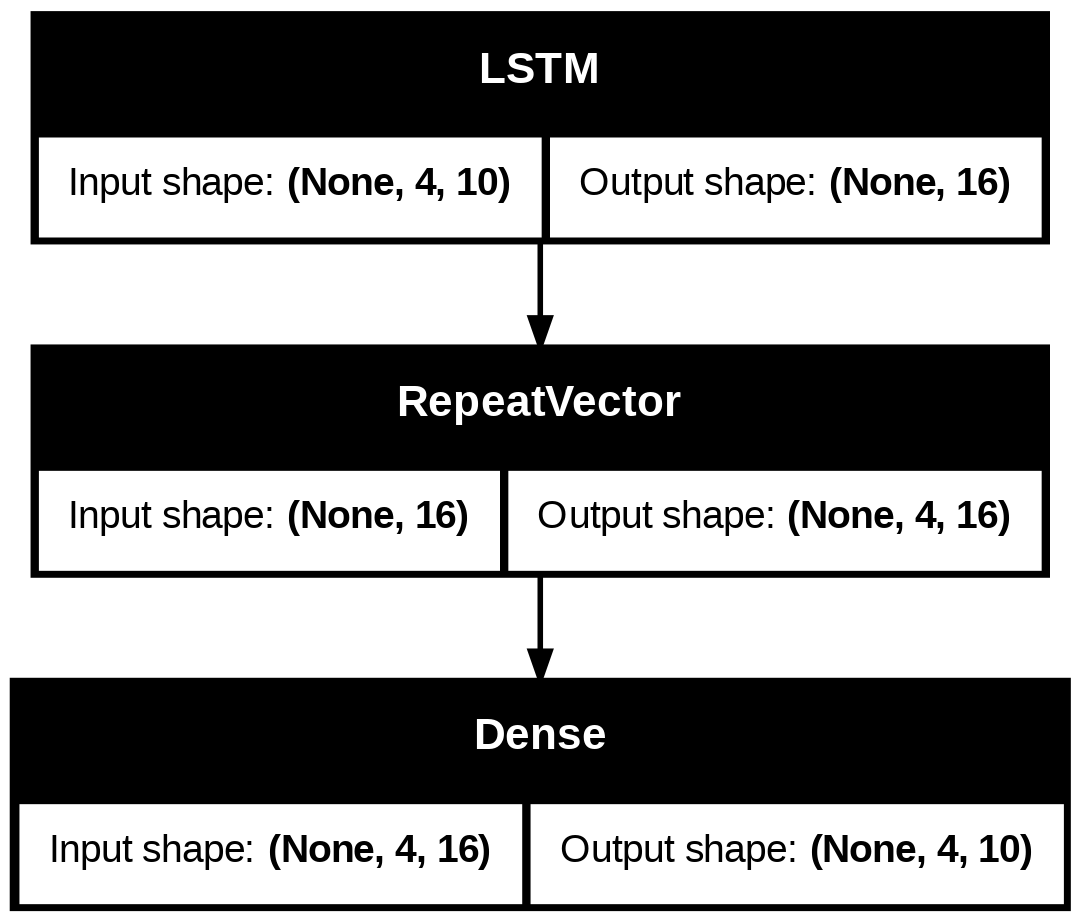

In [11]:
model = Sequential(name='Single_LSTM_Model')
model.add(InputLayer(input_shape=(n_timesteps, n_features)))

# Single LSTM Layer with default output
model.add(LSTM(numberOfUnits))
# Repeat the output of LSTM n_timesteps (4 in our example)
model.add(RepeatVector(n_timesteps))
# Dense layer recieves 4 x LSTM outputs as input vector
model.add(Dense(n_features, activation='softmax'))


model.compile(loss='categorical_crossentropy',
                                        optimizer=Adam(),
                                        metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True, to_file='Single_LSTM_Model.png')



Training for 100 epochs

Epoch 1: val_loss improved from inf to 2.23238, saving model to lstm_model.keras

Epoch 2: val_loss improved from 2.23238 to 2.12024, saving model to lstm_model.keras

Epoch 3: val_loss improved from 2.12024 to 1.94469, saving model to lstm_model.keras

Epoch 4: val_loss improved from 1.94469 to 1.75881, saving model to lstm_model.keras

Epoch 5: val_loss improved from 1.75881 to 1.62345, saving model to lstm_model.keras

Epoch 6: val_loss improved from 1.62345 to 1.55290, saving model to lstm_model.keras

Epoch 7: val_loss improved from 1.55290 to 1.50889, saving model to lstm_model.keras

Epoch 8: val_loss improved from 1.50889 to 1.47146, saving model to lstm_model.keras

Epoch 9: val_loss improved from 1.47146 to 1.44235, saving model to lstm_model.keras

Epoch 10: val_loss improved from 1.44235 to 1.41720, saving model to lstm_model.keras

Epoch 11: val_loss improved from 1.41720 to 1.39974, saving model to lstm_model.keras

Epoch 12: val_loss improved fro

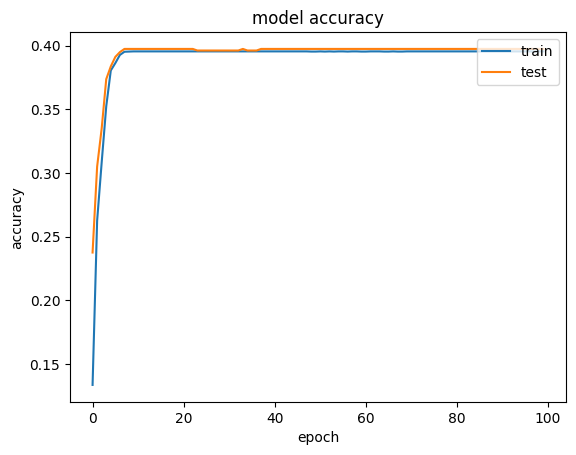

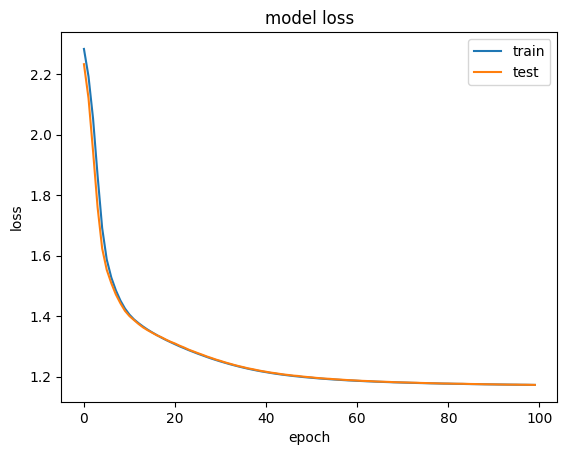

Some examples...
Input [5, 1, 9, 5] Expected: [5, 9, 1, 5] Predicted [5, 5, 5, 5]  False
Input [6, 5, 1, 6] Expected: [6, 1, 5, 6] Predicted [6, 6, 6, 6]  False
Input [4, 9, 5, 4] Expected: [4, 5, 9, 4] Predicted [4, 4, 4, 4]  False
Input [4, 4, 3, 2] Expected: [2, 3, 4, 4] Predicted [4, 4, 4, 4]  False
Input [2, 5, 6, 3] Expected: [3, 6, 5, 2] Predicted [5, 5, 5, 5]  False
Input [8, 5, 7, 9] Expected: [9, 7, 5, 8] Predicted [9, 9, 9, 9]  False
Input [1, 4, 6, 3] Expected: [3, 6, 4, 1] Predicted [1, 1, 1, 1]  False
Input [4, 5, 5, 3] Expected: [3, 5, 5, 4] Predicted [5, 5, 5, 5]  False
Input [6, 2, 5, 6] Expected: [6, 5, 2, 6] Predicted [6, 6, 6, 6]  False
Input [5, 8, 1, 6] Expected: [6, 1, 8, 5] Predicted [6, 6, 6, 6]  False


In [12]:
train_test(model,
           X_train, y_train , X_test, y_test,
           verbose=0)

#### We can see that prediction accuracy is below 40%...
#### Now lets try using Multiple LSTM Layers

**Note**: In order to increment a model capacity & improve accuracy, ***in general***, we could increment
* number of units
*  number of layers
*  number of epochs
*  number of training samples

We can try all of them on above model.

However, incrementing the LSTM unit number does not help!

Let's increment the **number of LSTM layers**


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "multiple_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 10)               │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

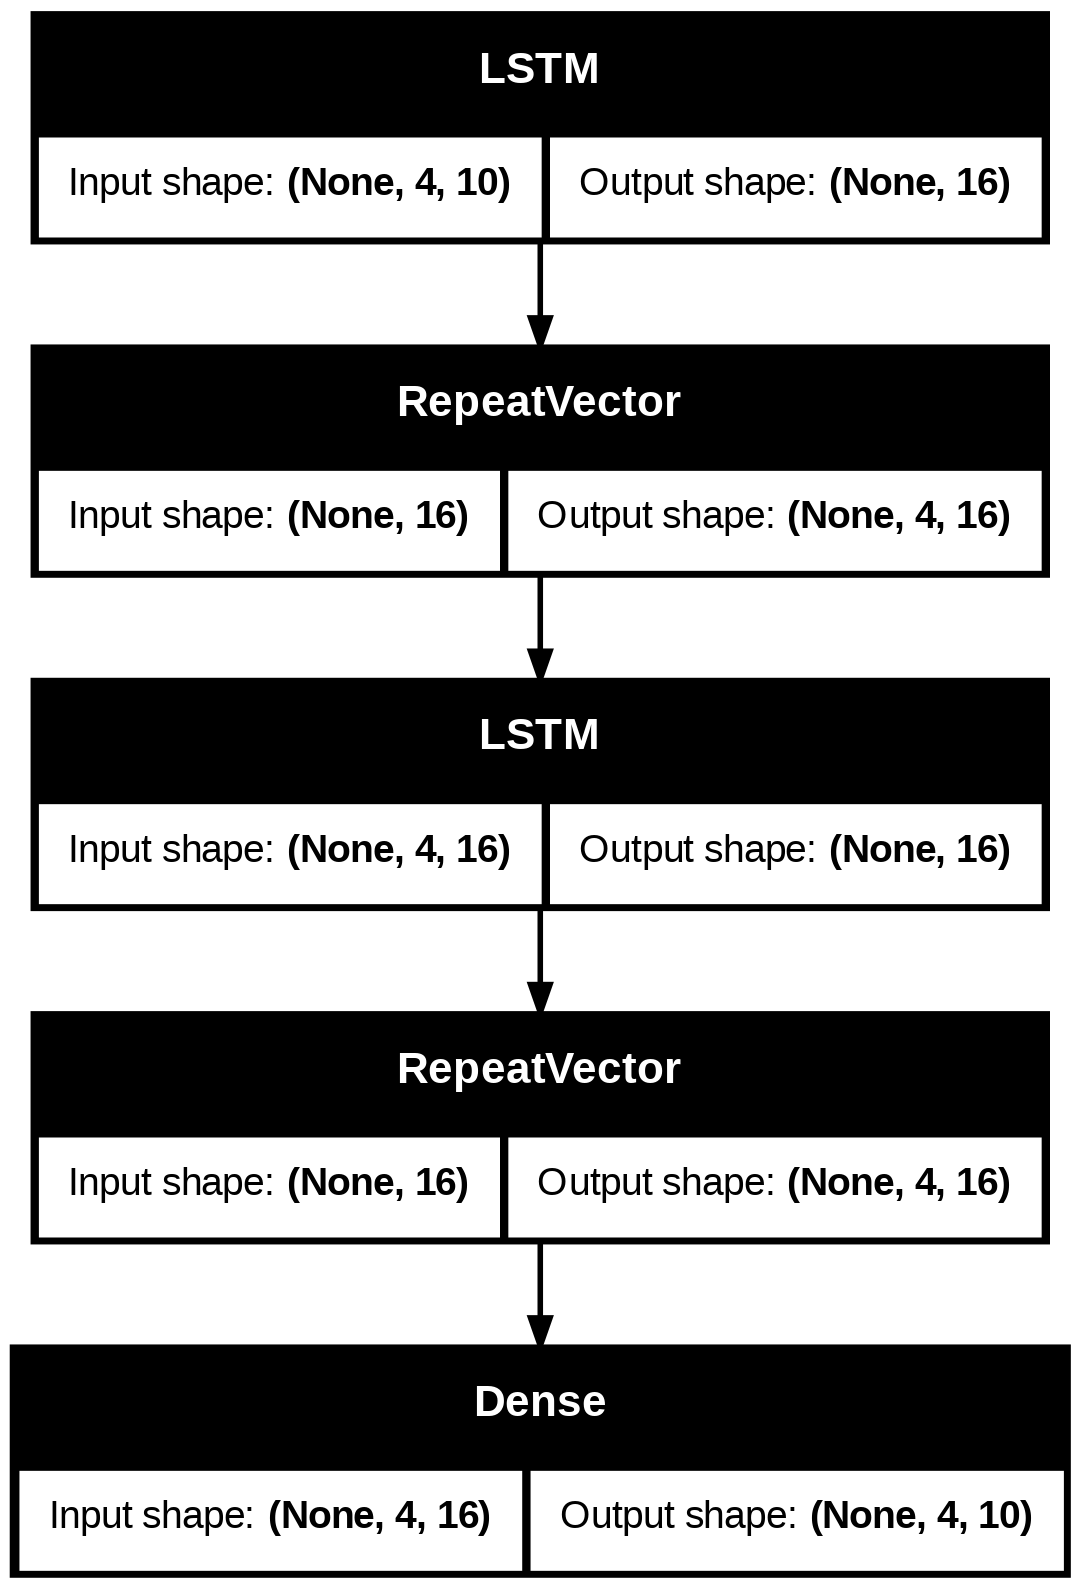

In [13]:
model = Sequential(name="multiple_LSTM_model")

model.add(InputLayer(input_shape=(n_timesteps, n_features)))

model.add(LSTM(numberOfUnits))
model.add(RepeatVector(n_timesteps))

model.add(LSTM(numberOfUnits))
model.add(RepeatVector(n_timesteps))

model.add(Dense(n_features, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True, to_file='multiple_LSTM_model.png')

Training for 100 epochs

Epoch 1: val_loss improved from inf to 2.21249, saving model to lstm_model.keras

Epoch 2: val_loss improved from 2.21249 to 1.88377, saving model to lstm_model.keras

Epoch 3: val_loss improved from 1.88377 to 1.63320, saving model to lstm_model.keras

Epoch 4: val_loss improved from 1.63320 to 1.55940, saving model to lstm_model.keras

Epoch 5: val_loss improved from 1.55940 to 1.51240, saving model to lstm_model.keras

Epoch 6: val_loss improved from 1.51240 to 1.48412, saving model to lstm_model.keras

Epoch 7: val_loss improved from 1.48412 to 1.45484, saving model to lstm_model.keras

Epoch 8: val_loss improved from 1.45484 to 1.42477, saving model to lstm_model.keras

Epoch 9: val_loss improved from 1.42477 to 1.39538, saving model to lstm_model.keras

Epoch 10: val_loss improved from 1.39538 to 1.37304, saving model to lstm_model.keras

Epoch 11: val_loss improved from 1.37304 to 1.35454, saving model to lstm_model.keras

Epoch 12: val_loss improved fro

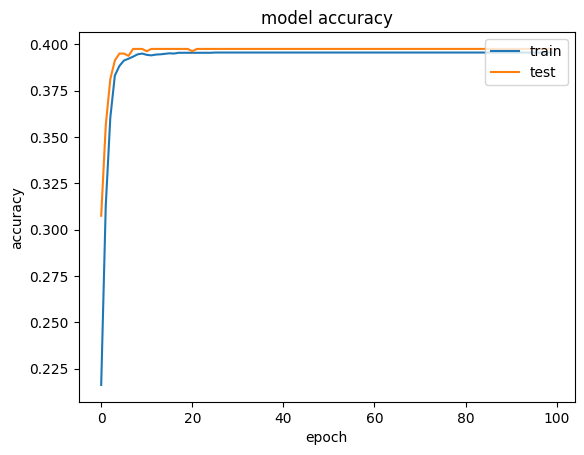

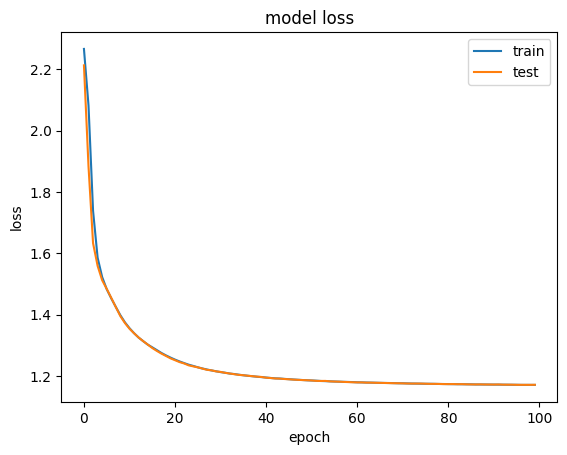

Some examples...
Input [2, 3, 3, 5] Expected: [5, 3, 3, 2] Predicted [3, 3, 3, 3]  False
Input [8, 4, 5, 6] Expected: [6, 5, 4, 8] Predicted [6, 6, 6, 6]  False
Input [8, 1, 1, 2] Expected: [2, 1, 1, 8] Predicted [1, 1, 1, 1]  False
Input [3, 3, 3, 2] Expected: [2, 3, 3, 3] Predicted [3, 3, 3, 3]  False
Input [1, 2, 4, 1] Expected: [1, 4, 2, 1] Predicted [1, 1, 1, 1]  False
Input [7, 2, 5, 4] Expected: [4, 5, 2, 7] Predicted [4, 4, 4, 4]  False
Input [7, 4, 5, 6] Expected: [6, 5, 4, 7] Predicted [6, 6, 6, 6]  False
Input [9, 8, 1, 7] Expected: [7, 1, 8, 9] Predicted [8, 8, 8, 8]  False
Input [4, 3, 3, 9] Expected: [9, 3, 3, 4] Predicted [3, 3, 3, 3]  False
Input [7, 7, 8, 9] Expected: [9, 8, 7, 7] Predicted [7, 7, 7, 7]  False


In [15]:
train_test(model, X_train, y_train , X_test, y_test, verbose=0)

#### No change in Accuracy

- Now we connect the Multiple LSTM Layers using return_sequences=True,

- This will make it so at each timestep the hidden state of the layer is passed to the next layer, it still is only a single output so we can use Sequential API

- We also need to use a TimeDistributed layer so that for each timestep of the second LSTM's output, the dense layer will generate one prediction

Model: "multiple_LSTM_model_with_return_sequences"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 4, 16)               │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 4, 16)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 4, 10)               │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

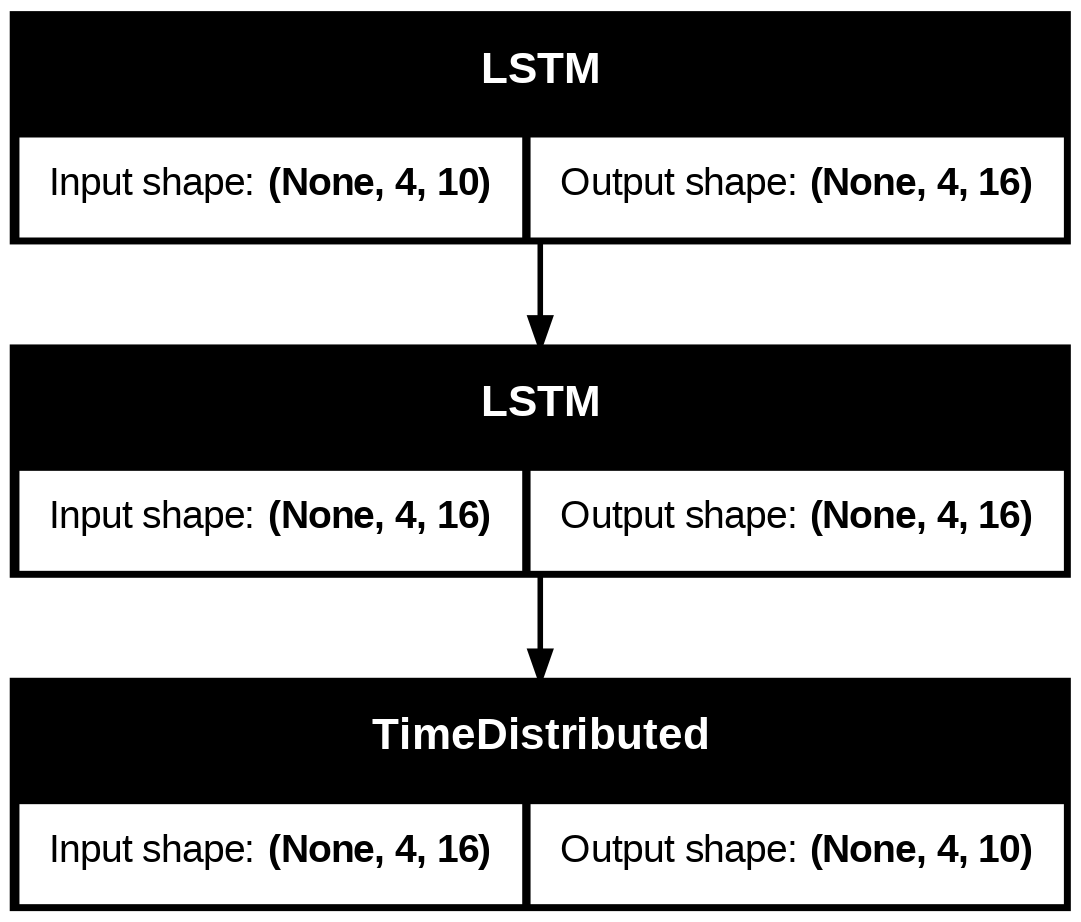

In [17]:
model = Sequential(name="multiple_LSTM_model_with_return_sequences")

model.add(InputLayer(shape=(n_timesteps, n_features)))

model.add(LSTM(numberOfUnits, return_sequences=True))
# we do not need to duplicate the output of first layer
# as it is being passed to next layer at each timestep hence having expected 3 dimensions

model.add(LSTM(numberOfUnits, return_sequences=True))

# output of second LSTM layer has 3 dimensions
# we need to supply these outputs one by one to Dense layer
# hence we use a time distributed layer

model.add(TimeDistributed(Dense(n_features, activation="softmax")))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True, to_file='multiple_LSTM_model_with_return_sequences.png')


Training for 100 epochs

Epoch 1: val_loss improved from inf to 2.25169, saving model to lstm_model.keras

Epoch 2: val_loss improved from 2.25169 to 2.12268, saving model to lstm_model.keras

Epoch 3: val_loss improved from 2.12268 to 1.94795, saving model to lstm_model.keras

Epoch 4: val_loss improved from 1.94795 to 1.79829, saving model to lstm_model.keras

Epoch 5: val_loss improved from 1.79829 to 1.73026, saving model to lstm_model.keras

Epoch 6: val_loss improved from 1.73026 to 1.68628, saving model to lstm_model.keras

Epoch 7: val_loss improved from 1.68628 to 1.65327, saving model to lstm_model.keras

Epoch 8: val_loss improved from 1.65327 to 1.62623, saving model to lstm_model.keras

Epoch 9: val_loss improved from 1.62623 to 1.60439, saving model to lstm_model.keras

Epoch 10: val_loss improved from 1.60439 to 1.58661, saving model to lstm_model.keras

Epoch 11: val_loss improved from 1.58661 to 1.57392, saving model to lstm_model.keras

Epoch 12: val_loss improved fro

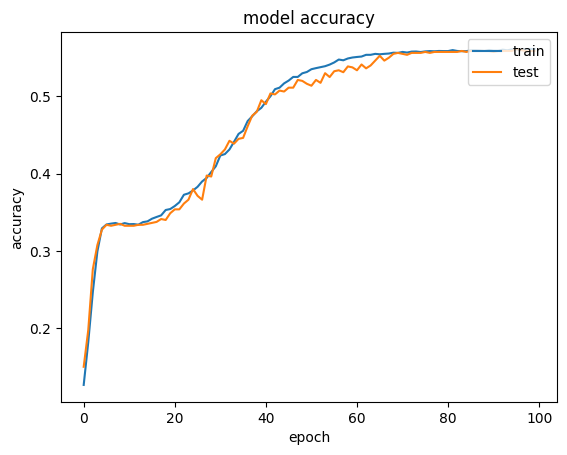

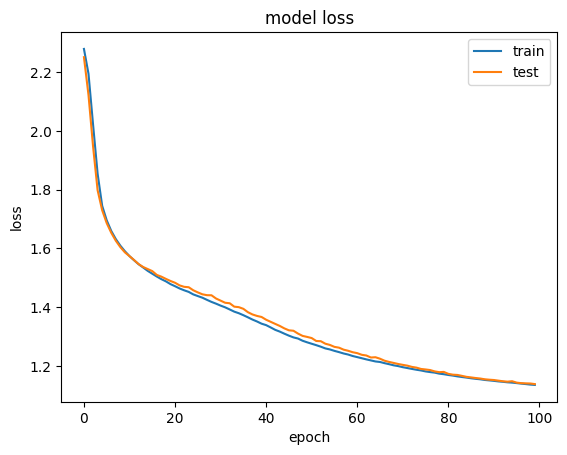

Some examples...
Input [9, 7, 7, 4] Expected: [4, 7, 7, 9] Predicted [4, 5, 7, 9]  False
Input [4, 6, 5, 3] Expected: [3, 5, 6, 4] Predicted [8, 6, 6, 4]  False
Input [2, 4, 3, 8] Expected: [8, 3, 4, 2] Predicted [8, 4, 4, 2]  False
Input [3, 7, 1, 3] Expected: [3, 1, 7, 3] Predicted [4, 2, 7, 3]  False
Input [1, 7, 3, 2] Expected: [2, 3, 7, 1] Predicted [8, 7, 7, 1]  False
Input [8, 8, 6, 2] Expected: [2, 6, 8, 8] Predicted [1, 8, 8, 8]  False
Input [1, 7, 7, 2] Expected: [2, 7, 7, 1] Predicted [8, 7, 7, 1]  False
Input [9, 7, 3, 4] Expected: [4, 3, 7, 9] Predicted [4, 5, 7, 9]  False
Input [3, 3, 6, 7] Expected: [7, 6, 3, 3] Predicted [4, 3, 3, 3]  False
Input [6, 6, 8, 2] Expected: [2, 8, 6, 6] Predicted [4, 6, 6, 6]  False


In [19]:
train_test(model, X_train, y_train , X_test, 	y_test)

#### Accuracy improved

We can further improve it by connecting the LSTM layers using return_state=True, which will provide
- LSTM Output
- Last_Hidden_State
- Last_cell_state

We must use functional API for this as sequential models can only return a single output tensor

Model: "Multiple_LSTM_with_return_state"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 4, 10)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, 16), (None,    │          1,728 │ input_layer_5[0][0]    │
│                           │ 16), (None, 16)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 4, 16)          │              0 │ lstm_8[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 4, 16)          │          2,112 │ repeat_vector_3[0][0], │
│                           │                        │                │ lstm_8[0][1],          │
│                           │                        │                │ lstm_8[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 4, 10)          │            170 │ lstm_9[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

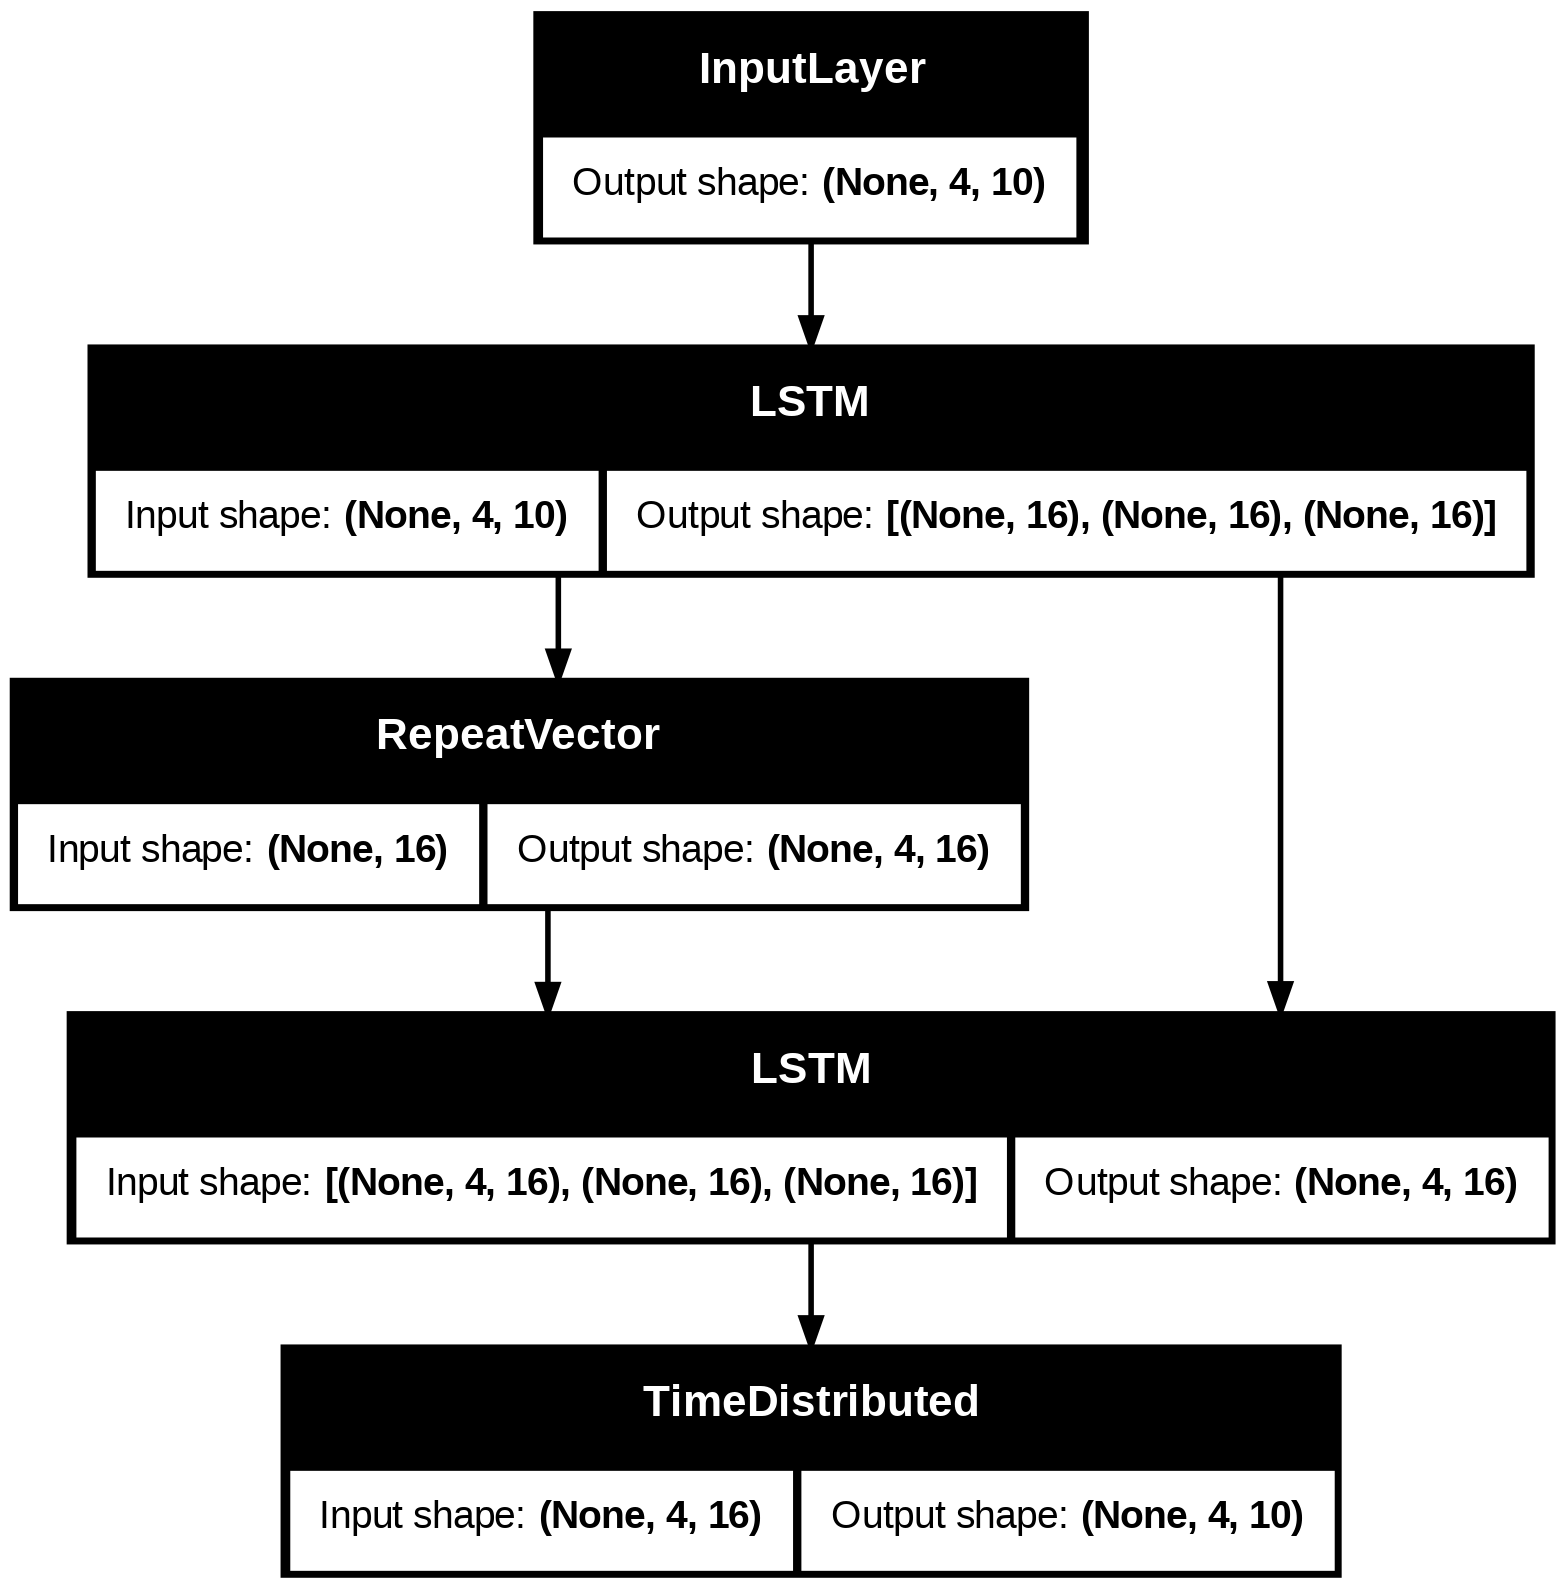

In [22]:
#@title LSTM with return_state=True output
input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model = Model(input,output,name='Multiple_LSTM_with_return_state')
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True, to_file='Multiple_LSTM_with_return_states.png')


Training for 100 epochs

Epoch 1: val_loss improved from inf to 2.21410, saving model to lstm_model.keras

Epoch 2: val_loss improved from 2.21410 to 1.94296, saving model to lstm_model.keras

Epoch 3: val_loss improved from 1.94296 to 1.69478, saving model to lstm_model.keras

Epoch 4: val_loss improved from 1.69478 to 1.57549, saving model to lstm_model.keras

Epoch 5: val_loss improved from 1.57549 to 1.50106, saving model to lstm_model.keras

Epoch 6: val_loss improved from 1.50106 to 1.43768, saving model to lstm_model.keras

Epoch 7: val_loss improved from 1.43768 to 1.39190, saving model to lstm_model.keras

Epoch 8: val_loss improved from 1.39190 to 1.35443, saving model to lstm_model.keras

Epoch 9: val_loss improved from 1.35443 to 1.31975, saving model to lstm_model.keras

Epoch 10: val_loss improved from 1.31975 to 1.29276, saving model to lstm_model.keras

Epoch 11: val_loss improved from 1.29276 to 1.26575, saving model to lstm_model.keras

Epoch 12: val_loss improved fro

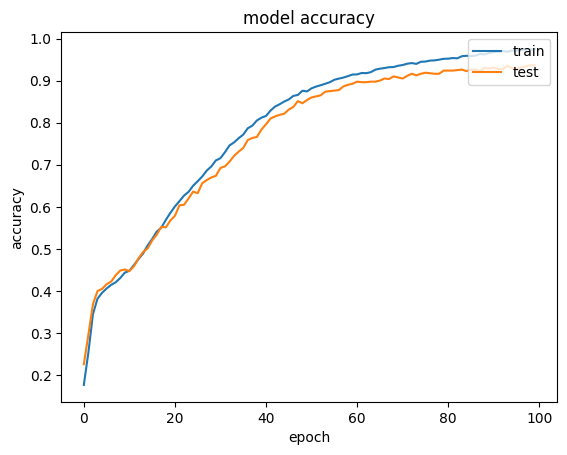

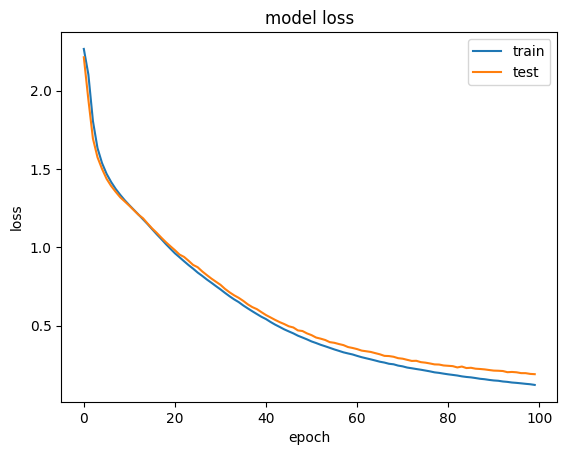

Some examples...
Input [4, 9, 1, 5] Expected: [5, 1, 9, 4] Predicted [5, 1, 9, 4]  True
Input [2, 4, 3, 7] Expected: [7, 3, 4, 2] Predicted [7, 3, 4, 2]  True
Input [1, 1, 3, 2] Expected: [2, 3, 1, 1] Predicted [2, 3, 1, 1]  True
Input [8, 4, 4, 9] Expected: [9, 4, 4, 8] Predicted [9, 4, 4, 8]  True
Input [7, 1, 3, 5] Expected: [5, 3, 1, 7] Predicted [5, 3, 1, 7]  True
Input [5, 5, 4, 8] Expected: [8, 4, 5, 5] Predicted [4, 4, 5, 5]  False
Input [5, 7, 3, 2] Expected: [2, 3, 7, 5] Predicted [2, 3, 7, 5]  True
Input [1, 6, 4, 1] Expected: [1, 4, 6, 1] Predicted [1, 4, 6, 1]  True
Input [1, 9, 5, 2] Expected: [2, 5, 9, 1] Predicted [2, 5, 9, 1]  True
Input [1, 2, 2, 9] Expected: [9, 2, 2, 1] Predicted [9, 2, 2, 1]  True


In [24]:
train_test(model, X_train, y_train , X_test, 	y_test)

#### We can see that the accuracy has risen to 90%

- Now we use both return_sequences and return_state as inputs to the next layer

- We know that by returning both we can get 4 different sets of outputs

* As the **last** option, a model containing multiple LSTM layer which are ***connected to each other*** by **return_sequences=True & return_state=True**
* Remember that when **return_sequences=True & return_state=True**  LSTM layer will return **3 arrays** of real numbers:
1. All Hidden States (Hidden State of ALL the time steps)
2. Last Hidden State (Hidden State of the last time step)
3. Last Cell State (Cell State of the last time step)


* As an input for the next LSTM layer we can use the 1st output [All Hidden States] but since it is **3D [batchsize, timesteps, features]**  we do not need to use **RepeatVector** as we did above.

* The second and the third outputs will be used as the initial states to the Second LSTM layer.

Model: "Multiple_LSTM_with_return_state_and_return_sequences"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 4, 10)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, 4, 16), (None, │          1,728 │ input_layer_6[0][0]    │
│                           │ 16), (None, 16)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, 4, 16), (None, │          2,112 │ lstm_10[0][0],         │
│                           │ 16), (None, 16)]       │                │ lstm_10[0][1],         │
│                           │                        │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 4, 10)          │            170 │ lstm_11[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

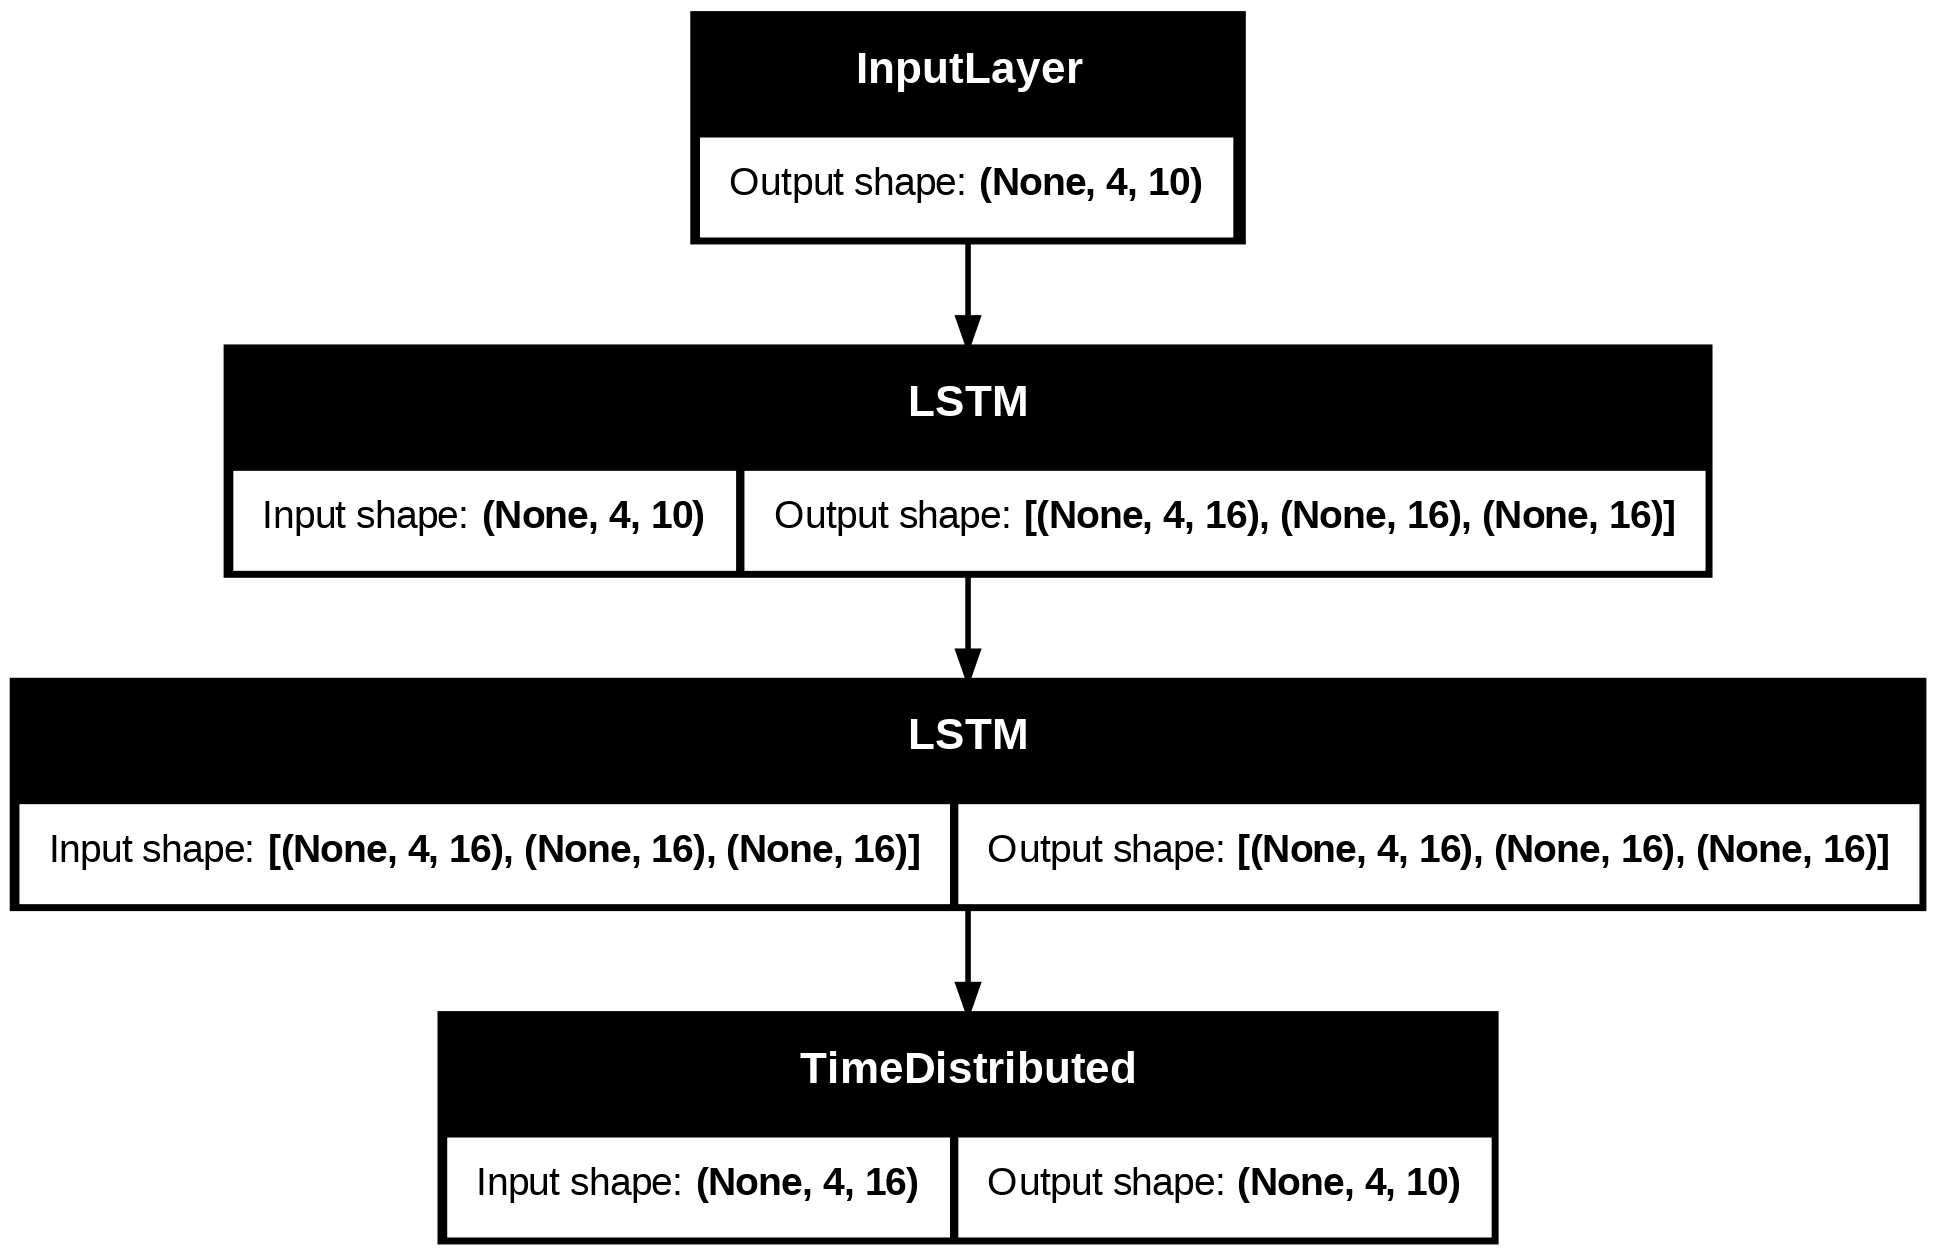

In [25]:
input = Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits, return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c] # list of previous hidden state and cell state

lstm2 = LSTM(numberOfUnits, return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm2(all_state_h, initial_state=states)

dense = TimeDistributed(Dense(n_features, activation="softmax"))
output = dense(all_state_h)

model = Model(input,output,
              name='Multiple_LSTM_with_return_state_and_return_sequences')

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True, to_file='Multiple_LSTM_with_return_state_and_return_sequences.png')

Training for 100 epochs

Epoch 1: val_loss improved from inf to 2.22441, saving model to lstm_model.keras

Epoch 2: val_loss improved from 2.22441 to 1.99791, saving model to lstm_model.keras

Epoch 3: val_loss improved from 1.99791 to 1.70355, saving model to lstm_model.keras

Epoch 4: val_loss improved from 1.70355 to 1.57547, saving model to lstm_model.keras

Epoch 5: val_loss improved from 1.57547 to 1.49948, saving model to lstm_model.keras

Epoch 6: val_loss improved from 1.49948 to 1.44535, saving model to lstm_model.keras

Epoch 7: val_loss improved from 1.44535 to 1.40381, saving model to lstm_model.keras

Epoch 8: val_loss improved from 1.40381 to 1.36465, saving model to lstm_model.keras

Epoch 9: val_loss improved from 1.36465 to 1.32685, saving model to lstm_model.keras

Epoch 10: val_loss improved from 1.32685 to 1.28368, saving model to lstm_model.keras

Epoch 11: val_loss improved from 1.28368 to 1.23886, saving model to lstm_model.keras

Epoch 12: val_loss improved fro

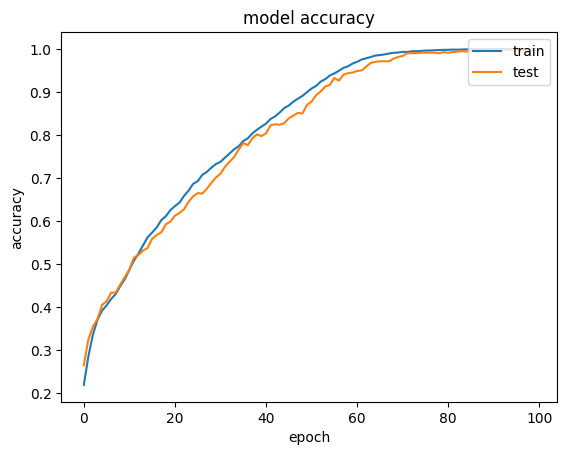

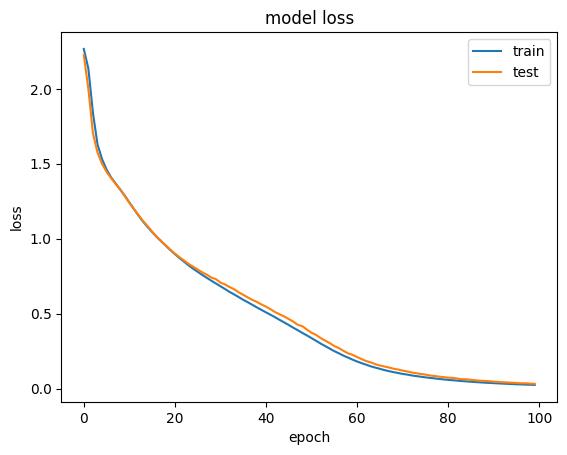

Some examples...
Input [2, 5, 2, 6] Expected: [6, 2, 5, 2] Predicted [6, 2, 5, 2]  True
Input [9, 2, 9, 2] Expected: [2, 9, 2, 9] Predicted [2, 9, 2, 9]  True
Input [3, 7, 2, 1] Expected: [1, 2, 7, 3] Predicted [1, 2, 7, 3]  True
Input [1, 9, 9, 2] Expected: [2, 9, 9, 1] Predicted [2, 9, 9, 1]  True
Input [4, 5, 6, 8] Expected: [8, 6, 5, 4] Predicted [8, 6, 5, 2]  False
Input [7, 5, 7, 4] Expected: [4, 7, 5, 7] Predicted [4, 7, 5, 7]  True
Input [4, 6, 9, 8] Expected: [8, 9, 6, 4] Predicted [8, 9, 6, 4]  True
Input [2, 4, 3, 8] Expected: [8, 3, 4, 2] Predicted [8, 3, 4, 2]  True
Input [3, 9, 1, 3] Expected: [3, 1, 9, 3] Predicted [3, 1, 9, 3]  True
Input [1, 2, 7, 1] Expected: [1, 7, 2, 1] Predicted [1, 7, 2, 1]  True


In [27]:
train_test(model, X_train, y_train , X_test, 	y_test)

**NOTES**:
* PREDICTION ACCURACY AT TEST DATA (%) has improved (previous models: **39** **56** to **90**) to **97**

* Again this observation indicates that **how to connect** multiple LSTM layers is **important**.

* If we compare the latest model with the previous models it is clear that we are exchanging **more information** between LSTM layers **even though the number of parameters  is same!**

In the **latest model**, we have  provided
* previous LSTM's **last hidden and cell states** as **initial values** to the next LSTM layer's hidden and cell states
*  previous LSTM's **all hidden states as inputs**  to the next LSTM layer

In other words, **Second LSTM layer**:
* **starts** to operate with last hidden states and cell states of the First LSTM layer
*  **consumes** the First LSTM layer's all hidden states to produce the output

As a result, during training,
*  Second LSTM layer is conditioned to produce expected outputs given the  First LSTM layer's outputs.
* First LSTM layer is conditioned to produce such outputs that Second LSTM layer would be successful in prediction.

Thus:

* We can argue that ***First LSTM layer encodes the input (X)*** in a represantation  that ***Second LSTM layer can decode*** it to produce the expected output (y)

* The encoded represantation of the input (X) in the last model is composed of the all hidden states + last hidden + cell states

* That is the **context vector** is [all hidden states + last hidden + cell states] of the First LSTM layer

* The **First LSTM layer is called as Encoder** whereas the **Second LSTM layer  is called as Decoder**

* We can use more LSTM layers to construct Encoder or Decoder as well





## PREDICTION ACCURACY AT TEST DATA (%) FOR **4 MODELS** (100 Epochs 16 LSTM Cells) WITH **INCREASING INPUT TIMESTEPS**

Sequence Size=4
 * **38.625** - **54.875** -  **91.625** - **97.250**

Sequence Size=8
 * **29.625** - **34.688** -  **50.375** - **56.437**

Sequence Size=16
 * **23.344** - **23.281** -  **33.344** - **37.469**

All the models ***degrade*** their performance when we request them to deal with **longer sequences**!



### How to handle longer sequences?
**Generic** Solution in ANN: Increment the model capacity!

In order to increment a model capacity & improve accuracy, we could
* increment number of units
* increment number of layers
* increment number of epochs
* increment number of training samples

However, even the length of the input sequence is increased a little bit (e.g. from 4 to 8), the model **can not catch up with** it to provide similar accuracy applying all above measures!

For example: when sequence size is 16, **doubling the LSTM cell numbers** to 32, last model performance **improves only  10%** (from 37.469% to 47.219%)


### Moreover: Input or/and Output sequence length would be NOT fixed!
* If we change the problem such that:
output sequence is the inverse of the input sequence **and** **only consists of the first appereance of duplicated numbers**!

**Ex:**
* INPUT: [3,2,3,5,2]
* OUTPUT: [2,5,3]

**Notice that**:
* output sequences do **NOT** have a **fixed** length!
* output sequences **DO** have a **variable** length!

NOTE:
1. **Input sequence** length would also be **variable**
2. Both  **Input and Output sequence** length could be **variable**!


**Ex:**
* Sentence Translation from language A to B
* **Each sentece** in language A and B has varying number of words!

**New Questions**:
* How can you **create** a model to handle v**ariable-length** input/output?
* How can you **train** such a model?

# A BETTER SOLUTION
* We can change the model structure!
* So far, we use a single model for training and inference
* Next we can use an Encoder, Decoder Architecture